In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, global_mean_pool
from torch_geometric.utils import to_undirected
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from tqdm import tqdm
from safetensors.torch import save_model

In [2]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = "cpu"

### Data Processing

In [3]:
df = pd.read_csv('new_signs_en.csv')
df.head()

,Landmark 0 x,Landmark 0 y,Landmark 0 z,Landmark 1 x,Landmark 1 y,Landmark 1 z,Landmark 2 x,Landmark 2 y,Landmark 2 z,Landmark 3 x,...,Landmark 18 x,Landmark 18 y,Landmark 18 z,Landmark 19 x,Landmark 19 y,Landmark 19 z,Landmark 20 x,Landmark 20 y,Landmark 20 z,Label
0,-0.037993,0.057931,0.004442,-0.047266,0.026725,-0.006041,-0.052424,0.004474,-0.006988,-0.053588,...,0.024683,0.009273,-0.007357,0.032078,0.003632,-0.014625,0.030489,0.004943,-0.023943,okay
1,-0.005646,0.075994,0.001298,0.024656,0.051832,0.011561,0.045452,0.035231,0.015494,0.067561,...,-0.027572,-0.010882,-0.016814,-0.033732,-0.024054,-0.022971,-0.035903,-0.032292,-0.027351,okay
2,-0.014400,0.090823,-0.004294,0.012813,0.065451,0.008774,0.036500,0.047876,0.019436,0.062467,...,-0.007362,-0.006102,-0.036582,0.012183,-0.015052,-0.044667,0.027297,-0.014695,-0.049022,okay
3,-0.013171,0.094140,-0.017708,0.015044,0.069322,0.002030,0.038452,0.046146,0.016647,0.060131,...,-0.010004,-0.009738,-0.039137,0.001193,-0.031637,-0.046446,0.013007,-0.041953,-0.054871,okay
4,-0.016094,0.089002,0.006281,0.012828,0.063034,0.021948,0.039463,0.044607,0.030844,0.062926,...,-0.026367,-0.004472,-0.036807,-0.025791,-0.026992,-0.042681,-0.023097,-0.041298,-0.055171,okay


In [4]:
df = df.sample(frac=1, ignore_index=True, random_state=42)
df.head()

,Landmark 0 x,Landmark 0 y,Landmark 0 z,Landmark 1 x,Landmark 1 y,Landmark 1 z,Landmark 2 x,Landmark 2 y,Landmark 2 z,Landmark 3 x,...,Landmark 18 x,Landmark 18 y,Landmark 18 z,Landmark 19 x,Landmark 19 y,Landmark 19 z,Landmark 20 x,Landmark 20 y,Landmark 20 z,Label
0,-0.010239,0.056995,0.048322,0.014969,0.036082,0.040442,0.038195,0.026444,0.030233,0.060492,...,-0.026535,-0.004289,-0.007332,-0.024540,-0.021687,-0.014291,-0.018570,-0.033478,-0.021973,okay
1,-0.020437,0.019301,0.076203,-0.009364,-0.003245,0.060962,-0.005217,-0.022624,0.044543,-0.001038,...,-0.001497,0.026727,0.004575,-0.006822,0.025387,0.015516,-0.013840,0.022895,0.016418,good
2,-0.019664,-0.077246,-0.038224,-0.011665,-0.062105,-0.008706,-0.006520,-0.034435,0.020129,0.000842,...,0.004231,0.021520,-0.033625,0.005288,0.049189,-0.033678,0.004688,0.066439,-0.032394,not good
3,0.031481,0.086567,0.007161,-0.002998,0.072879,0.002860,-0.023507,0.061872,-0.004079,-0.048201,...,0.032392,-0.018827,-0.016040,0.029501,-0.039913,-0.023004,0.027531,-0.053760,-0.034915,okay
4,-0.025002,0.080575,0.023477,0.007310,0.065296,0.022222,0.030048,0.055826,0.017053,0.048943,...,-0.034807,-0.009838,-0.026401,-0.034057,-0.029552,-0.034812,-0.034171,-0.045054,-0.046899,okay


In [5]:
features = df.drop(columns=['Label'])
features.shape

(1712, 63)

In [6]:
labels = df['Label']
labels.unique()

array(['okay', 'good', 'not good'], dtype=object)

In [7]:
le = LabelEncoder()
labels = le.fit_transform(labels)

labels.shape

(1712,)

![](hand_landmarks.png)

Edge index of hand landmarks are constant. Edge index is a 2D matrix with 2 rows. First row represents origin and second row represents end. Per column, it lists all the connections the graph makes. Essentially it is one of the matrix representations of a graph. Undirected does both a to b and b to a.

In [8]:
# make edge index
edge_index = torch.tensor([
    [0, 0, 0, 1, 2, 3, 5, 5, 6, 7, 9, 9, 10, 11, 13, 13, 14, 15, 17, 18, 19],
    [1, 5, 17, 2, 3, 4, 6, 9, 7, 8, 10, 13, 11, 12, 17, 14, 15, 16, 18, 19, 20]
    ], dtype=torch.long).to(device)

# make it undirected
edge_index = to_undirected(edge_index)

In [9]:
features = features.to_numpy()
features = features.reshape(-1, 21, 3)

In [10]:
datas = []
for i in range(len(features)):
    data = Data(
        x=torch.tensor(features[i], dtype=torch.float).to(device), 
        edge_index=edge_index,
        y=torch.tensor(labels[i], dtype=torch.long).to(device)
    )
    datas.append(data)

In [11]:
split = int(len(datas) * 0.8)

train_dl = DataLoader(datas[:split], batch_size=16)
test_dl = DataLoader(datas[split:], batch_size=16)

In [12]:
sample = next(iter(train_dl))
sample

DataBatch(x=[336, 3], edge_index=[2, 672], y=[16], batch=[336], ptr=[17])

### Model Creation

In [13]:
class GCN(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(input_channels, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, output_channels)
        
    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)

        x = global_mean_pool(x, batch)

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x

model = GCN(3, 32, 3).to(device)
print(model)

GCN(
  (conv1): GraphConv(3, 32)
  (conv2): GraphConv(32, 32)
  (lin): Linear(in_features=32, out_features=3, bias=True)
)


In [14]:
model(sample.x, sample.edge_index, sample.batch)

tensor([[ 0.0576,  0.2683,  0.0655],
        [ 0.1509, -0.0291, -0.1804],
        [-0.0712,  0.3305,  0.1580],
        [-0.1457,  0.5117,  0.0321],
        [ 0.0529,  0.5302,  0.2190],
        [-0.0205,  0.5187, -0.0635],
        [-0.1590,  0.5102,  0.3038],
        [ 0.1287,  0.3567, -0.1146],
        [-0.0683,  0.2813,  0.2816],
        [-0.0246,  0.6572, -0.1135],
        [-0.0724,  0.4881,  0.1190],
        [-0.1764,  0.6836, -0.1667],
        [-0.0143,  0.3027,  0.1323],
        [-0.0443,  0.5173,  0.1361],
        [-0.2434,  0.3191,  0.0688],
        [ 0.0349,  0.4050,  0.1172]], grad_fn=<AddmmBackward0>)

In [15]:
sample.y

tensor([2, 0, 1, 2, 2, 1, 1, 2, 2, 0, 1, 1, 2, 1, 2, 2])

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-2)

### Model Training

In [17]:
torch.manual_seed(42)

epochs = 50

train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------")
    
    # TRAINING
    train_loss, train_correct =  0, 0
    model.train()
    for data in train_dl:

        # forward pass
        pred = model(data.x, data.edge_index, data.batch)

        # metrics
        loss = loss_fn(pred, data.y)
        train_loss += loss
        train_correct += int((pred.argmax(dim=1) == data.y).sum())
        train_acc = train_correct/len(train_dl.dataset)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # print metrics
    train_loss /= len(train_dl)
    train_losses.append(train_loss.item())
    train_accs.append(train_acc)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}")


    # TESTING
    test_loss, test_correct = 0, 0
    model.eval()
    with torch.inference_mode():
        for data in test_dl:

            # forward pass
            pred = model(data.x, data.edge_index, data.batch)

            # metrics
            loss = loss_fn(pred, data.y)
            test_loss += loss
            test_correct += int((pred.argmax(dim=1) == data.y).sum())
            test_acc = test_correct/len(test_dl.dataset)

        # print metrics
        test_loss /= len(test_dl)
        test_losses.append(test_loss.item())
        test_accs.append(test_acc)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
------


  2%|▏         | 1/50 [00:00<00:17,  2.86it/s]

Train Loss: 0.6475, Train Accuracy: 0.69
Test Loss: 0.0466, Test Accuracy: 0.99
Epoch: 1
------


  4%|▍         | 2/50 [00:00<00:17,  2.75it/s]

Train Loss: 0.0285, Train Accuracy: 0.99
Test Loss: 0.0232, Test Accuracy: 1.00
Epoch: 2
------


  6%|▌         | 3/50 [00:01<00:15,  3.00it/s]

Train Loss: 0.0233, Train Accuracy: 0.99
Test Loss: 0.0330, Test Accuracy: 0.99
Epoch: 3
------


  8%|▊         | 4/50 [00:01<00:13,  3.35it/s]

Train Loss: 0.0279, Train Accuracy: 0.99
Test Loss: 0.0395, Test Accuracy: 0.99
Epoch: 4
------


 10%|█         | 5/50 [00:01<00:14,  3.18it/s]

Train Loss: 0.0340, Train Accuracy: 0.99
Test Loss: 0.0003, Test Accuracy: 1.00
Epoch: 5
------


 12%|█▏        | 6/50 [00:01<00:13,  3.16it/s]

Train Loss: 0.0274, Train Accuracy: 0.99
Test Loss: 0.0002, Test Accuracy: 1.00
Epoch: 6
------


 14%|█▍        | 7/50 [00:02<00:13,  3.23it/s]

Train Loss: 0.0274, Train Accuracy: 1.00
Test Loss: 0.0057, Test Accuracy: 1.00
Epoch: 7
------


 16%|█▌        | 8/50 [00:02<00:12,  3.36it/s]

Train Loss: 0.0250, Train Accuracy: 0.99
Test Loss: 0.0054, Test Accuracy: 1.00
Epoch: 8
------


 18%|█▊        | 9/50 [00:02<00:11,  3.53it/s]

Train Loss: 0.0172, Train Accuracy: 1.00
Test Loss: 0.0069, Test Accuracy: 1.00
Epoch: 9
------


 20%|██        | 10/50 [00:03<00:11,  3.44it/s]

Train Loss: 0.0127, Train Accuracy: 1.00
Test Loss: 0.0043, Test Accuracy: 1.00
Epoch: 10
------


 22%|██▏       | 11/50 [00:03<00:11,  3.54it/s]

Train Loss: 0.0142, Train Accuracy: 1.00
Test Loss: 0.0106, Test Accuracy: 1.00
Epoch: 11
------


 24%|██▍       | 12/50 [00:03<00:10,  3.64it/s]

Train Loss: 0.0176, Train Accuracy: 0.99
Test Loss: 0.0012, Test Accuracy: 1.00
Epoch: 12
------


 26%|██▌       | 13/50 [00:03<00:10,  3.70it/s]

Train Loss: 0.0163, Train Accuracy: 1.00
Test Loss: 0.0044, Test Accuracy: 1.00
Epoch: 13
------


 28%|██▊       | 14/50 [00:04<00:09,  3.71it/s]

Train Loss: 0.0195, Train Accuracy: 1.00
Test Loss: 0.0002, Test Accuracy: 1.00
Epoch: 14
------


 30%|███       | 15/50 [00:04<00:09,  3.75it/s]

Train Loss: 0.0133, Train Accuracy: 1.00
Test Loss: 0.0023, Test Accuracy: 1.00
Epoch: 15
------


 32%|███▏      | 16/50 [00:04<00:09,  3.61it/s]

Train Loss: 0.0126, Train Accuracy: 1.00
Test Loss: 0.0009, Test Accuracy: 1.00
Epoch: 16
------


 34%|███▍      | 17/50 [00:04<00:09,  3.64it/s]

Train Loss: 0.0089, Train Accuracy: 1.00
Test Loss: 0.0003, Test Accuracy: 1.00
Epoch: 17
------


 36%|███▌      | 18/50 [00:05<00:08,  3.68it/s]

Train Loss: 0.0105, Train Accuracy: 1.00
Test Loss: 0.0063, Test Accuracy: 1.00
Epoch: 18
------


 38%|███▊      | 19/50 [00:05<00:08,  3.72it/s]

Train Loss: 0.0128, Train Accuracy: 1.00
Test Loss: 0.0021, Test Accuracy: 1.00
Epoch: 19
------


 40%|████      | 20/50 [00:05<00:08,  3.70it/s]

Train Loss: 0.0093, Train Accuracy: 1.00
Test Loss: 0.0012, Test Accuracy: 1.00
Epoch: 20
------


 42%|████▏     | 21/50 [00:06<00:07,  3.70it/s]

Train Loss: 0.0144, Train Accuracy: 1.00
Test Loss: 0.0007, Test Accuracy: 1.00
Epoch: 21
------


 44%|████▍     | 22/50 [00:06<00:07,  3.69it/s]

Train Loss: 0.0113, Train Accuracy: 0.99
Test Loss: 0.0001, Test Accuracy: 1.00
Epoch: 22
------


 46%|████▌     | 23/50 [00:06<00:07,  3.43it/s]

Train Loss: 0.0117, Train Accuracy: 1.00
Test Loss: 0.0033, Test Accuracy: 1.00
Epoch: 23
------


 48%|████▊     | 24/50 [00:06<00:07,  3.44it/s]

Train Loss: 0.0104, Train Accuracy: 1.00
Test Loss: 0.0007, Test Accuracy: 1.00
Epoch: 24
------


 50%|█████     | 25/50 [00:07<00:07,  3.24it/s]

Train Loss: 0.0073, Train Accuracy: 1.00
Test Loss: 0.0002, Test Accuracy: 1.00
Epoch: 25
------


 52%|█████▏    | 26/50 [00:07<00:07,  3.25it/s]

Train Loss: 0.0155, Train Accuracy: 1.00
Test Loss: 0.0002, Test Accuracy: 1.00
Epoch: 26
------


 54%|█████▍    | 27/50 [00:07<00:07,  3.18it/s]

Train Loss: 0.0103, Train Accuracy: 1.00
Test Loss: 0.0001, Test Accuracy: 1.00
Epoch: 27
------


 56%|█████▌    | 28/50 [00:08<00:06,  3.29it/s]

Train Loss: 0.0085, Train Accuracy: 1.00
Test Loss: 0.0002, Test Accuracy: 1.00
Epoch: 28
------


 58%|█████▊    | 29/50 [00:08<00:06,  3.36it/s]

Train Loss: 0.0108, Train Accuracy: 1.00
Test Loss: 0.0009, Test Accuracy: 1.00
Epoch: 29
------


 60%|██████    | 30/50 [00:08<00:05,  3.44it/s]

Train Loss: 0.0064, Train Accuracy: 1.00
Test Loss: 0.0051, Test Accuracy: 1.00
Epoch: 30
------


 62%|██████▏   | 31/50 [00:09<00:05,  3.47it/s]

Train Loss: 0.0170, Train Accuracy: 0.99
Test Loss: 0.0001, Test Accuracy: 1.00
Epoch: 31
------


 64%|██████▍   | 32/50 [00:09<00:05,  3.51it/s]

Train Loss: 0.0144, Train Accuracy: 1.00
Test Loss: 0.0012, Test Accuracy: 1.00
Epoch: 32
------


 66%|██████▌   | 33/50 [00:09<00:04,  3.51it/s]

Train Loss: 0.0080, Train Accuracy: 1.00
Test Loss: 0.0000, Test Accuracy: 1.00
Epoch: 33
------


 68%|██████▊   | 34/50 [00:09<00:04,  3.50it/s]

Train Loss: 0.0306, Train Accuracy: 0.99
Test Loss: 0.0001, Test Accuracy: 1.00
Epoch: 34
------


 70%|███████   | 35/50 [00:10<00:04,  3.39it/s]

Train Loss: 0.0134, Train Accuracy: 1.00
Test Loss: 0.0025, Test Accuracy: 1.00
Epoch: 35
------


 72%|███████▏  | 36/50 [00:10<00:04,  3.40it/s]

Train Loss: 0.0118, Train Accuracy: 1.00
Test Loss: 0.0012, Test Accuracy: 1.00
Epoch: 36
------


 74%|███████▍  | 37/50 [00:10<00:03,  3.40it/s]

Train Loss: 0.0149, Train Accuracy: 1.00
Test Loss: 0.0001, Test Accuracy: 1.00
Epoch: 37
------


 76%|███████▌  | 38/50 [00:11<00:03,  3.23it/s]

Train Loss: 0.0062, Train Accuracy: 1.00
Test Loss: 0.0141, Test Accuracy: 1.00
Epoch: 38
------


 78%|███████▊  | 39/50 [00:11<00:03,  3.35it/s]

Train Loss: 0.0132, Train Accuracy: 1.00
Test Loss: 0.0037, Test Accuracy: 1.00
Epoch: 39
------


 80%|████████  | 40/50 [00:11<00:03,  3.24it/s]

Train Loss: 0.0049, Train Accuracy: 1.00
Test Loss: 0.0000, Test Accuracy: 1.00
Epoch: 40
------


 82%|████████▏ | 41/50 [00:11<00:02,  3.38it/s]

Train Loss: 0.0087, Train Accuracy: 1.00
Test Loss: 0.0000, Test Accuracy: 1.00
Epoch: 41
------


 84%|████████▍ | 42/50 [00:12<00:02,  3.45it/s]

Train Loss: 0.0255, Train Accuracy: 1.00
Test Loss: 0.0022, Test Accuracy: 1.00
Epoch: 42
------


 86%|████████▌ | 43/50 [00:12<00:02,  3.32it/s]

Train Loss: 0.0164, Train Accuracy: 0.99
Test Loss: 0.0009, Test Accuracy: 1.00
Epoch: 43
------


 88%|████████▊ | 44/50 [00:12<00:01,  3.38it/s]

Train Loss: 0.0129, Train Accuracy: 1.00
Test Loss: 0.0003, Test Accuracy: 1.00
Epoch: 44
------


 90%|█████████ | 45/50 [00:13<00:01,  3.21it/s]

Train Loss: 0.0044, Train Accuracy: 1.00
Test Loss: 0.0013, Test Accuracy: 1.00
Epoch: 45
------


 92%|█████████▏| 46/50 [00:13<00:01,  3.33it/s]

Train Loss: 0.0108, Train Accuracy: 1.00
Test Loss: 0.0016, Test Accuracy: 1.00
Epoch: 46
------


 94%|█████████▍| 47/50 [00:13<00:00,  3.33it/s]

Train Loss: 0.0069, Train Accuracy: 1.00
Test Loss: 0.0016, Test Accuracy: 1.00
Epoch: 47
------


 96%|█████████▌| 48/50 [00:14<00:00,  3.22it/s]

Train Loss: 0.0027, Train Accuracy: 1.00
Test Loss: 0.0002, Test Accuracy: 1.00
Epoch: 48
------


 98%|█████████▊| 49/50 [00:14<00:00,  3.36it/s]

Train Loss: 0.0007, Train Accuracy: 1.00
Test Loss: 0.0000, Test Accuracy: 1.00
Epoch: 49
------


100%|██████████| 50/50 [00:14<00:00,  3.40it/s]

Train Loss: 0.0096, Train Accuracy: 1.00
Test Loss: 0.0000, Test Accuracy: 1.00


### Model Evaluation

Text(0, 0.5, 'Accuracy')

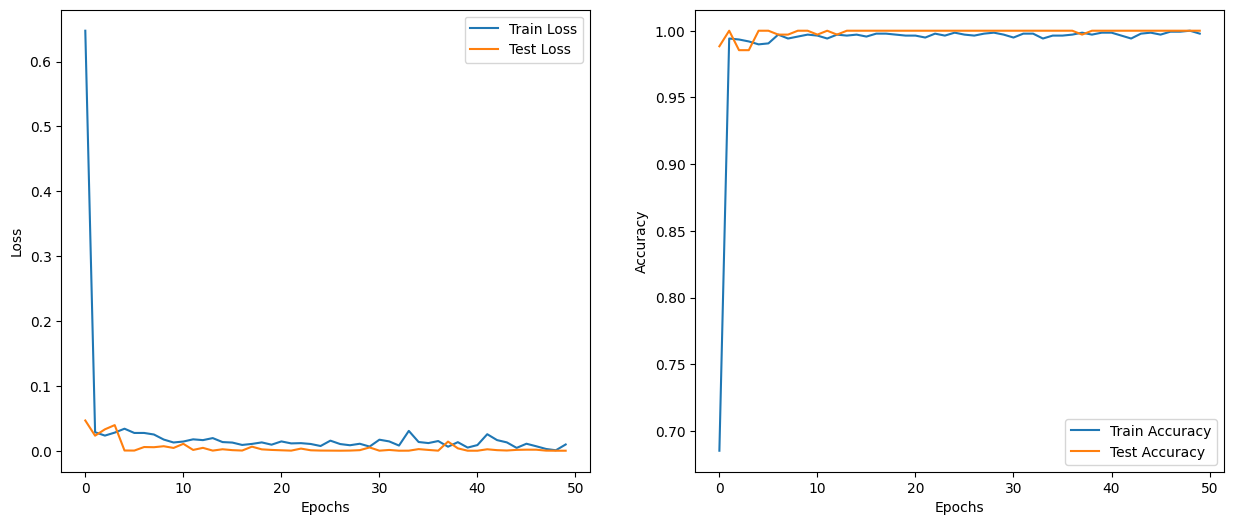

In [18]:
plt.figure(figsize=(15, 6))

plt.subplot(121)
sns.lineplot(x=range(epochs), y=train_losses, label='Train Loss')
sns.lineplot(x=range(epochs), y=test_losses, label='Test Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(122)
sns.lineplot(x=range(epochs), y=train_accs, label='Train Accuracy')
sns.lineplot(x=range(epochs), y=test_accs, label='Test Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [19]:
joblib.dump(le, 'label_encoder.pkl')
save_model(model, 'gnn.safetensors')